# Hamiltonian Simulation by Generalized Quantum Signal Processing

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `HamiltonianSimulationByGQSP`
Hamiltonian simulation using Generalized QSP given a qubitized quantum walk operator.

Given the Szegedy Quantum Walk Operator for a Hamiltonian $H$ constructed from SELECT and PREPARE oracles,
one can construct a block-encoding of $e^{-iHt}$ using GQSP (Corollary 8).

### Recap: Qubitization Walk Operator

For a Hamiltonian $H = \sum_j \alpha_j U_j$ where $U_j$ are unitaries and $\alpha_j \ge 0$,
we are given the SELECT and PREPARE oracles:
$$ \text{SELECT} = \sum_j |j\rangle\langle j| \otimes U_j $$
$$ \text{PREPARE} |0\rangle = \sum_j \frac{\sqrt{\alpha_j}}{\|\alpha\|_1} |j\rangle $$

We can then implement the [QubitizationWalkOperator](../qubitization_walk_operator.ipynb) that encodes the spectrum of $H$ in the eigenphases of the walk operator $W$.

### Approximating the function $e^{i\theta} \mapsto e^{it\cos\theta}$

We can use the [Jacobi-Anger expansion](https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion) to obtain low-degree polynomial approximations for the $\cos$ function:

$$
    e^{it\cos\theta} = \sum_{n = -\infty}^{\infty} i^n J_n(t) (e^{i\theta})^n
$$
where $J_n$ is the $n$-th [Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function#Bessel_functions_of_the_first_kind).

If we cut-off the above to terms upto degree $d$, we get

$$
    P[t](z) = \sum_{n = -d}^d i^n J_n(t) z^n
$$

Polynomial approximations of the above are provided in the [`qualtran.linalg.jacobi_anger_approximations`](../../linalg/jacobi_anger_approximations.py) module.

### Simulation: Block-encoding $e^{-iHt}$

As the eigenphases of the walk operator above are $e^{-i\arccos(E_k / \|\alpha\|_1)}$,
we can use the GQSP polynomial with $P = P[-\|\alpha\|_1 t]$ to obtain $P(U) = e^{-iHt}$.
The obtained GQSP operator $G$ can then be used with two calls to the PREPARE oracle to simulate the hamiltonian:

$$
    (I \otimes \text{PREPARE}^\dagger \otimes I) G (I \otimes \text{PREPARE} \otimes I) |0\rangle|0\rangle|\psi\rangle = |0\rangle|0\rangle e^{-iHt}|\psi\rangle
$$

This therefore block-encodes $e^{-iHt}$ in the block where the signal qubit and selection registers are all $|0\rangle$.

#### References
 - [Generalized Quantum Signal Processing](https://arxiv.org/abs/2308.01501). Motlagh and Wiebe. (2023). Theorem 7, Corollary 8. 

#### Parameters
 - `walk_operator`: qubitization walk operator of $H$ constructed from SELECT and PREPARE oracles.
 - `t`: time to simulate the Hamiltonian, i.e. $e^{-iHt}$
 - `precision`: the precision $\epsilon$ to approximate $e^{it\cos\theta}$ to a polynomial.


In [2]:
from qualtran.bloqs.hamiltonian_simulation.hamiltonian_simulation_by_gqsp import HamiltonianSimulationByGQSP

### Example Instances

In [3]:
from qualtran.bloqs.hubbard_model import get_walk_operator_for_hubbard_model

walk_op = get_walk_operator_for_hubbard_model(2, 2, 1, 1)
hubbard_time_evolution_by_gqsp = HamiltonianSimulationByGQSP(walk_op, t=5, precision=1e-7)

In [4]:
import sympy

from qualtran.bloqs.hubbard_model import get_walk_operator_for_hubbard_model

walk_op = get_walk_operator_for_hubbard_model(2, 2, 1, 1)

t, inv_eps = sympy.symbols("t N")
symbolic_hamsim_by_gqsp = HamiltonianSimulationByGQSP(walk_op, t=t, precision=1 / inv_eps)

#### Graphical Signature

In [5]:
from qualtran.drawing import show_bloqs
show_bloqs([hubbard_time_evolution_by_gqsp, symbolic_hamsim_by_gqsp],
           ['`hubbard_time_evolution_by_gqsp`', '`symbolic_hamsim_by_gqsp`'])

### Call Graph

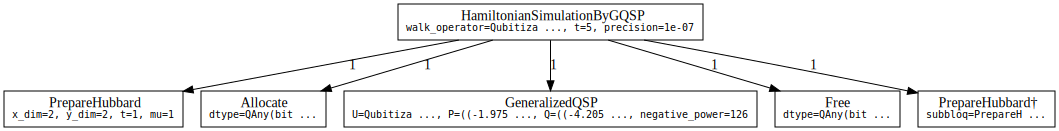

#### Counts totals:
 - `Adjoint(subbloq=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1))`: 1
 - `Allocate(dtype=QAny(bitsize=2))`: 1
 - `Free(dtype=QAny(bitsize=2))`: 1
 - `GeneralizedQSP(U=QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=None), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1), control_val=None), P=((-1.9755231893196262e-07+5.813700424667883e-22j), (8.074934502229654e-21-4.0196720883208893e-07j), (8.073657031482692e-07+1.1866852864170136e-20j), (-1.4895485360217115e-20+1.6002997349756333e-06j), (-3.1293716448916645e-06-1.2259725857523251e-20j), (-8.888110446107158e-21-6.035367078560083e-06j), (1.1476216685223932e-05+2.4741272017318007e-19j), (-3.4774342163817624e-19+2.150755296597717e-05j), (-3.971175937380019e-05-4.2801849686977626e-19j), (3.8906683169350837e-19-7.221219915619495e-05j), (0.00012926478665169176-3.2004959972048963e-22j), (1.2278392293127759e-18+0.00022768210587573555j), (-0.00039440405686249225-6.956746358471438e-18j), (8.225474604888907e-18-0.0006715591437707574j), (0.0011233196080594158+7.703750669604769e-18j), (-2.707467556762307e-18+0.001844676778282317j), (-0.00297186283972734+1.1657380558680887e-17j), (8.968575979465387e-17-0.004693421469117867j), (0.007259795962949476+9.959365664358286e-17j), (-9.150826718847833e-17+0.01098773781085294j), (-0.016253962952276057-4.775275111044433e-17j), (-5.755918565233746e-17-0.023470663647972612j), (0.033034430708465894-2.5907884428777188e-16j), (-6.871519393024941e-16+0.04524095222563658j), (-0.06016193087634563-5.894914067664724e-16j), (3.4158170164803995e-16-0.0774893867621085j), (0.0963666303831136-9.465066466751858e-17j), 0.11524387400411877j, (-0.13181624014504126+0j), -0.14311595668016208j, (0.1458287158144735+0j), 0.13687517768362692j, (-0.11423412178441764+0j), -0.07788497127107763j, (0.030631924779787743+0j), -0.02152222967626938j, (0.06980238279059663+0j), 0.10412205934680566j, (-0.11553488284671565+0j), -0.09921933446341792j, (0.057106759119631534+0j), -0.0009957087776558968j, (0.05879946404164411+0j), 0.0977873908123062j, (-0.10352760470678421+0j), -0.07199788090681988j, (0.013108962362264016+0j), -0.051023541127197466j, (0.09372615734323601+0j), 0.09518926432825071j, (-0.05286530972227011+0j), 0.01483399355040015j, (-0.07511630004787033+0j), -0.09633813052044793j, (0.06553737051198368+0j), -0.0019643169831914356j, (0.06832670062811552+0j), 0.09369306389617028j, (-0.060969727548599494+0j), 0.010774234430074988j, (-0.07540720168489998+0j), -0.08876327179399299j, (0.039985051647290916+0j), -0.03758240568546062j, (0.0873388828109713+0j), 0.0707178090001438j, (0.001063155830795861+0j), 0.07199359599709883j, (-0.08388928744578075+0j), -0.02531797744000685j, (-0.05502679316417295+0j), -0.08694798578388055j, (0.04061599119809567+0j), -0.04308271528993723j, (0.08628366940542913+0j), 0.04665230089170906j, (0.03869832249588588+0j), 0.08535062338759494j, (-0.04494528842395717+0j), 0.04220314650059606j, (-0.08461624613451744+0j), -0.03564379994316j, (-0.05253682618567346+0j), -0.08187620698655264j, (0.01787671182276182+0j), -0.0668597690554327j, (0.07270172244821663+0j), -0.008698391096859406j, (0.07948646750376695+0j), 0.05171132420600348j, (0.041220087591324374+0j), 0.08138978727175702j, (-0.015752763498905545+0j), 0.07067790809250124j, (-0.06240018283995637+0j), 0.03074179107492917j, (-0.08146009330641245+0j), -0.018134264908918302j, (-0.07094221965923984+0j), -0.05786190791809261j, (-0.03969678938346983+0j), -0.07850423839749693j, (-0.0004446701847213649+0j), -0.07871768008616317j, (0.0357654626549137+0j), -0.06298087651800115j, (0.06221743079247418+0j), -0.038093904201011476j, (0.07669311438885854+0j), -0.010484383021022394j, (0.08025780461600616+0j), 0.01519811445609958j, (0.07569837027917581+0j), 0.03639365813426776j, (0.06623601916426618+0j), 0.05229030273369165j, (0.05473215256285403+0j), 0.06323673324626244j, (0.04334954057852679+0j), 0.07017265973882673j, (0.03352536821509105+0j), 0.07419570392463767j, (0.026105797822627275+0j), 0.07628416775044787j, (0.021528747757600403+0j), 0.07714531766075185j, (0.019985841404385366+0j), 0.07714531766075185j, (0.021528747757600403+0j), 0.07628416775044787j, (0.026105797822627275+0j), 0.07419570392463767j, (0.03352536821509105+0j), 0.07017265973882673j, (0.04334954057852679+0j), 0.06323673324626244j, (0.05473215256285403+0j), 0.05229030273369165j, (0.06623601916426618+0j), 0.03639365813426776j, (0.07569837027917581+0j), 0.01519811445609958j, (0.08025780461600616+0j), -0.010484383021022394j, (0.07669311438885854+0j), -0.038093904201011476j, (0.06221743079247418+0j), -0.06298087651800115j, (0.0357654626549137+0j), -0.07871768008616317j, (-0.0004446701847213649+0j), -0.07850423839749693j, (-0.03969678938346983+0j), -0.05786190791809261j, (-0.07094221965923984+0j), -0.018134264908918302j, (-0.08146009330641245+0j), 0.03074179107492917j, (-0.06240018283995637+0j), 0.07067790809250124j, (-0.015752763498905545+0j), 0.08138978727175702j, (0.041220087591324374+0j), 0.05171132420600348j, (0.07948646750376695+0j), -0.008698391096859406j, (0.07270172244821663+0j), -0.0668597690554327j, (0.01787671182276182+0j), -0.08187620698655264j, (-0.05253682618567346+0j), -0.03564379994316j, (-0.08461624613451744+0j), 0.04220314650059606j, (-0.04494528842395717+0j), 0.08535062338759494j, (0.03869832249588588+0j), 0.04665230089170906j, (0.08628366940542913+0j), -0.04308271528993723j, (0.04061599119809567+0j), -0.08694798578388055j, (-0.05502679316417295+0j), -0.02531797744000685j, (-0.08388928744578075+0j), 0.07199359599709883j, (0.001063155830795861+0j), 0.0707178090001438j, (0.0873388828109713+0j), -0.03758240568546062j, (0.039985051647290916+0j), -0.08876327179399299j, (-0.07540720168489998+0j), 0.010774234430074988j, (-0.060969727548599494+0j), 0.09369306389617028j, (0.06832670062811552+0j), -0.0019643169831914356j, (0.06553737051198368+0j), -0.09633813052044793j, (-0.07511630004787033+0j), 0.01483399355040015j, (-0.05286530972227011+0j), 0.09518926432825071j, (0.09372615734323601+0j), -0.051023541127197466j, (0.013108962362264016+0j), -0.07199788090681988j, (-0.10352760470678421+0j), 0.0977873908123062j, (0.05879946404164411+0j), -0.0009957087776558968j, (0.057106759119631534+0j), -0.09921933446341792j, (-0.11553488284671565+0j), 0.10412205934680566j, (0.06980238279059663+0j), -0.02152222967626938j, (0.030631924779787743+0j), -0.07788497127107763j, (-0.11423412178441764+0j), 0.13687517768362692j, (0.1458287158144735+0j), -0.14311595668016208j, (-0.13181624014504126+0j), 0.11524387400411877j, (0.0963666303831136+9.465066466751858e-17j), (-3.4158170164803995e-16-0.0774893867621085j), (-0.06016193087634563+5.894914067664724e-16j), (6.871519393024941e-16+0.04524095222563658j), (0.033034430708465894+2.5907884428777188e-16j), (5.755918565233746e-17-0.023470663647972612j), (-0.016253962952276057+4.775275111044433e-17j), (9.150826718847833e-17+0.01098773781085294j), (0.007259795962949476-9.959365664358286e-17j), (-8.968575979465387e-17-0.004693421469117867j), (-0.00297186283972734-1.1657380558680887e-17j), (2.707467556762307e-18+0.001844676778282317j), (0.0011233196080594158-7.703750669604769e-18j), (-8.225474604888907e-18-0.0006715591437707574j), (-0.00039440405686249225+6.956746358471438e-18j), (-1.2278392293127759e-18+0.00022768210587573555j), (0.00012926478665169176+3.2004959972048963e-22j), (-3.8906683169350837e-19-7.221219915619495e-05j), (-3.971175937380019e-05+4.2801849686977626e-19j), (3.4774342163817624e-19+2.150755296597717e-05j), (1.1476216685223932e-05-2.4741272017318007e-19j), (8.888110446107158e-21-6.035367078560083e-06j), (-3.1293716448916645e-06+1.2259725857523251e-20j), (1.4895485360217115e-20+1.6002997349756333e-06j), (8.073657031482692e-07-1.1866852864170136e-20j), (-8.074934502229654e-21-4.0196720883208893e-07j), (-1.9755231893196262e-07-5.813700424667883e-22j)), Q=((-4.2051529009145015e-11+3.899837683713282e-25j), (-4.790351800466709e-24-1.2518478964719635e-22j), (1.6988671879411024e-10-8.777619546015175e-21j), (1.4248225868054825e-23+4.465099196168354e-22j), (-6.495752829616211e-10+5.190815384623058e-20j), (-9.511919062260049e-23-2.741948238773806e-21j), (2.3475458529354698e-09-2.222393069630921e-19j), (2.7042150061301297e-22+1.0922198632317447e-20j), (-7.997692312184214e-09+8.434635270283093e-19j), (-1.0062195371646994e-21-3.8940696088273866e-20j), (2.5602047636628158e-08-2.9802839138954793e-18j), (3.219902518927038e-21+1.3226755816029973e-19j), (-7.672329953334482e-08+9.900093404209761e-18j), (-8.754109973332885e-21-4.2444226739239204e-19j), (2.1429911253405093e-07-3.095322478030677e-17j), (3.229964714298685e-20+1.2778988121991683e-18j), (-5.549850153252773e-07+9.07366517394565e-17j), (-8.371746549210299e-20-3.588581357344184e-18j), (1.3241272656823632e-06-2.4838770767599526e-16j), (1.851443948383047e-19+9.505152235872617e-18j), (-2.8871286353148765e-06+6.321022833930857e-16j), (-4.701057677633476e-19-2.3379712189929223e-17j), (5.6926694456136285e-06-1.4871570570017176e-15j), (9.530911456024034e-19+5.3263627468091065e-17j), (-1.0004310616987993e-05+3.213539991549638e-15j), (-1.8804230710533904e-18-1.1086768353169577e-16j), (1.5338277636206398e-05-6.324764360657851e-15j), (3.583751503565794e-18+2.1081345771919103e-16j), (-1.980338840229226e-05+1.1214791677322116e-14j), (-5.254880910888926e-18-3.6124730340346227e-16j), (2.0076644102721295e-05-1.7651144979675903e-14j), (7.830802926030556e-18+5.242516485216247e-16j), (-1.3079030973104792e-05+2.413948038829525e-14j), (-9.06724549329854e-18-6.86637772356153e-16j), (-5.173466405186606e-07-2.7734231078865695e-14j), (6.594360358762574e-18+7.196095741499659e-16j), (1.3578655560610355e-05+2.523991427316375e-14j), (3.297180179381287e-18-4.94577026907193e-16j), (-1.5560347982087437e-05-1.624850392399098e-14j), -7.91323243051509e-17j, (2.8767743561317525e-06+6.515228034457423e-15j), (-2.6377441435050296e-17+7.385683601814083e-16j), (1.26202918809136e-05-8.01874219625529e-15j), (-5.275488287010059e-17-2.0970065940864986e-15j), (-1.2335588176783567e-05+3.291904691094277e-14j), (-1.0550976574020118e-16+1.0550976574020118e-15j), (-4.960330646497832e-06-8.353735702480429e-14j), (-1.0550976574020118e-16-8.440781259216095e-16j), (1.5467877591235782e-05+1.4644755484739925e-13j), (2.1101953148040237e-16+4.114880863867846e-15j), (-2.5241515231397248e-06-1.9878039865453903e-13j), (4.2203906296080474e-16+0j), (-1.2177637334632717e-05+2.1713909789333404e-13j), (-7.12190918746358e-16+1.603748439251058e-14j), (6.814878613702879e-07-1.8485310957683247e-13j), 5.9085468814512665e-15j, (1.6931444370592204e-05+9.875714073282831e-14j), (3.376312503686438e-15-1.3083210951784947e-14j), (-5.5755361552596675e-06+2.025787502211863e-14j), (-1.688156251843219e-15+6.752625007372876e-15j), (-1.0856706891008056e-05-1.152166641882997e-13j), (3.376312503686438e-15-1.5193406266588972e-14j), (-3.730085061745237e-06+1.1817093762902533e-13j), 5.064468755529657e-15j, (1.2786764786844677e-05-2.025787502211863e-14j), (-6.752625007372876e-15+6.752625007372876e-15j), (9.922917228105808e-06-7.681110945886647e-14j), (-3.376312503686438e-15-1.0128937511059314e-14j), (-1.0193422907222629e-05+6.752625007372875e-14j), (1.0128937511059314e-14-1.9835835959157824e-14j), (-1.1319348843262505e-05+5.4021000058983006e-14j), (-5.064468755529657e-15+1.0128937511059314e-14j), (-2.8046785886516727e-06-9.327063291433784e-14j), (-2.5322343777648286e-15-6.752625007372876e-15j), (8.943136393462936e-06-3.376312503686438e-15j), (1.3505250014745752e-14+3.376312503686438e-15j), (1.4422039788459525e-05+6.752625007372875e-14j), (-1.1817093762902533e-14+8.440781259216094e-15j), (2.0818572402573013e-06+4.051575004423726e-14j), -1.3505250014745752e-14j, (-1.1226208336808372e-05-1.2872191420304545e-13j), (2.66939707322709e-14-1.688156251843219e-15j), (-1.0939837471590573e-05+3.882759379239404e-14j), (-3.1230890659099554e-14+3.713943754055082e-14j), (-8.324714711332523e-06+1.0128937511059314e-14j), (-3.376312503686438e-15-4.389206254792369e-14j), (2.540153591332944e-06+3.713943754055082e-14j), (4.726837505161013e-14+7.596703133294486e-15j), (1.2652395086815621e-05+4.726837505161013e-14j), (-3.376312503686438e-14+5.0644687555296566e-14j), (1.4080493261867958e-05-9.875714073282831e-14j), (-3.376312503686438e-14-5.0644687555296566e-14j), (6.353317630100391e-06-8.103150008847452e-14j), (4.726837505161013e-14-2.4478265651726676e-14j), (6.003870953867221e-07+6.077362506635589e-14j), (6.752625007372876e-15+4.051575004423726e-14j), (-6.135173539027209e-06+1.2914395326600625e-13j), (-3.54512812887076e-14-1.3505250014745752e-14j), (-1.4410615856580779e-05+6.752625007372876e-15j), (3.376312503686438e-14-1.1184035168461326e-14j), (-1.4094252994685044e-05-4.051575004423726e-14j), (-1.856971877027541e-14+6.077362506635589e-14j), (-9.749667103434457e-06-7.765518758478808e-14j), (-1.0466568761427957e-13-8.103150008847452e-14j), (-6.223370307752398e-06-2.0257875022118626e-13j), (1.6206300017694903e-13-1.0128937511059313e-13j), (-2.3780115331105646e-06+1.418051251548304e-13j), (7.005848445149359e-14+2.4309450026542355e-13j), (3.488551793703862e-06+3.106207503391523e-13j), (-3.038681253317794e-13-1.688156251843219e-14j), (9.489151754071481e-06-2.295892502506778e-13j), (1.2492356263639821e-13-2.9036287531703366e-13j), (1.1579823806863469e-05+3.376312503686438e-14j), (2.1946031273961847e-13+2.4309450026542355e-13j), (1.1031997132251884e-05+2.836102503096608e-13j), (-2.667286877912286e-13+7.849926571070969e-14j), (1.393157067497331e-05-3.173733753465252e-13j), (5.4021000058983006e-14-2.1270768773224559e-13j), (1.5869520860818062e-05-2.2790109399883456e-14j), (5.2332843807139786e-14+1.434932814066736e-13j), (1.482305782046426e-05-4.9800609429374956e-14j), (-1.1331748840497607e-13-1.2436963636626215e-13j), (1.3432682409307815e-05-3.9080817230170517e-13j), (2.31277406502521e-13+2.5322343777648286e-15j), (1.3828073649819728e-05+3.384753284945654e-13j), (-1.4750265250480126e-13+1.8907350020644053e-13j), (1.5367131934747528e-05+2.3634187525805066e-14j), (-2.025787502211863e-14-1.958261252138134e-13j), (1.608838770897997e-05-6.752625007372875e-14j), (4.051575004423726e-14+1.8907350020644053e-13j), (1.5145941417160146e-05+4.524258754939827e-13j), (-2.7348131279860146e-13-2.5659975028016926e-13j), (1.3804202640982289e-05-3.5113650038338954e-13j), (5.739731256266944e-13-9.453675010322026e-14j), (1.4792637548674171e-05+5.4021000058983e-13j), (-3.106207503391523e-13+7.208427195370545e-13j), (1.585788881261455e-05+4.3216800047186405e-13j), (-5.199521255677114e-13-7.292835007962706e-13j), (1.3772584615578891e-05-1.0061411260985585e-12j), (9.116043759953382e-13-3.376312503686438e-14j), (9.476641788649977e-06+7.394124383073299e-13j), (-4.963179380419064e-13+6.178651881746181e-13j), (4.538070510824048e-06+9.327063291433784e-14j), (3.291904691094277e-14-7.240607673921306e-13j), (-8.885800973772929e-07-4.878771567826903e-13j), (4.0684565669421577e-13+8.103150008847451e-13j), (-6.0838258289297705e-06+8.677123134474145e-13j), (-1.2357303763492362e-12-4.093778910719806e-13j), (-1.1322717876436435e-05-1.1006778762017788e-12j), (1.3302671264524566e-12-9.993885010911857e-13j), (-1.5860210847904773e-05+1.9835835959157823e-13j), (7.765518758478808e-14+1.9312507521086424e-12j), (-1.7346187395901615e-05+1.195214626304999e-12j), (-1.7691877519316935e-12-1.0491891105205606e-12j), (-1.2875543612431704e-05-1.742177251902202e-12j), (1.7624351269243205e-12-8.575833759363552e-13j), (-2.3401289219195775e-06+4.089558520090198e-13j), (-4.119101254497454e-13+1.6408878767916089e-12j), (9.891894274404873e-06+8.643360009437281e-13j), (-7.495413758183892e-13-1.216105559921559e-12j), (1.803825872325707e-05-8.035623758773722e-13j), (1.18002122003841e-12+5.435863130935165e-13j), (1.748493718782986e-05+8.921905790991412e-13j), (-1.6088129080065877e-12+3.038681253317794e-13j), (6.977846320449378e-06-7.005848445149359e-13j), (9.5971682917287e-13-1.843466627012795e-12j), (-9.012729525826516e-06-1.941379689619702e-13j), (1.2661171888824141e-12+2.0257875022118625e-12j), (-1.986510701857947e-05+1.9278744396049562e-12j), (-2.4305229635912743e-12+2.0257875022118626e-13j), (-1.6211882412788497e-05-9.082280634916518e-13j), (7.968097508699993e-13-1.9143691895902103e-12j), (1.2042745127031567e-06-5.604678756119487e-13j), (8.305728759068637e-13+1.2357303763492362e-12j), (1.8691845915585878e-05+1.0027648135948721e-12j), (-8.508307509289823e-13-2.70105000294915e-13j), (1.920533226765653e-05-1.0128937511059313e-13j), (8.103150008847451e-13+1.0888607824388762e-13j), (-3.1238284108220124e-07+3.106207503391523e-13j), (-1.1682041262755074e-12+7.022730007667791e-13j), (-2.042525533634188e-05-8.204439383958044e-13j), (8.103150008847452e-14-1.7826930019464392e-12j), (-1.6693434591681843e-05-9.048517509879654e-13j), (1.6476405017989816e-12+1.0399042511354228e-12j), (8.93871867931352e-06+1.3100092514303378e-12j), (-1.7202312206282401e-12+9.723780010616942e-13j), (2.245971310102121e-05-5.672205006193216e-13j), (5.4021000058983006e-14-1.850219252020168e-12j), (1.7732527207678193e-06-5.4021000058983e-13j), (1.4315565015630497e-12+9.8588325107644e-13j), (-2.2837102916086767e-05+1.580114251725253e-12j), (-1.4467499078296387e-12+6.212415006783046e-13j), (-8.048733642594286e-06-6.212415006783046e-13j), (4.0515750044237253e-13-1.3437723764672023e-12j), (2.4434641916550514e-05-3.5113650038338954e-13j), (7.562940008257621e-13+1.08042000117966e-12j), (1.2007357318729772e-05+6.887677507520333e-13j), (-1.3167618764377108e-12-8.103150008847452e-14j), (-2.5695863636311612e-05-1.2222251263344905e-12j), (8.508307509289823e-13-1.0466568761427958e-12j), (-9.325185340839015e-06+3.2412600035389806e-13j), (4.9294162553822e-13+1.2087198763197447e-12j), (2.8778938773504755e-05+1.2424830013566092e-12j), (-1.249235626363982e-12-1.1985909388086855e-13j), (-3.869925441439766e-06-8.812175634621603e-13j), (5.672205006193216e-13-9.87571407328283e-13j), (-3.141795723526174e-05-2.768576253022879e-13j), (6.313704381893639e-13+6.887677507520333e-13j), (2.2924147426165557e-05+4.760600630197877e-13j), (-5.942310006488131e-13+3.2412600035389806e-13j), (1.3960690613179527e-05-2.0257875022118626e-13j), (-6.752625007372875e-14-3.916522504276268e-13j), (-3.790308225819795e-05+1.0804200011796601e-13j), (2.0257875022118626e-13+1.3505250014745752e-14j), (2.7904037811300615e-05+2.5659975028016926e-13j), (2.1946031273961846e-14+1.2154725013271177e-13j), (7.810599296533279e-06-1.6206300017694903e-13j), (-9.453675010322026e-14+4.051575004423726e-14j), (-3.8684322577813356e-05-2.4309450026542355e-13j), -6.752625007372875e-14j, (5.591695782483836e-05+2.0257875022118626e-13j), (9.453675010322026e-14-2.7010500029491503e-14j), (-5.111995183496449e-05+1.4855775016220327e-13j), (1.3505250014745752e-14+6.752625007372875e-14j), (4.044542232249778e-05-2.0257875022118626e-13j), (-1.3505250014745752e-14+2.025787502211863e-14j), (-2.5225374826554157e-05+7.427887508110164e-14j), (2.584989260634929e-15-2.7010500029491503e-14j), (1.4931095375666815e-05+9.453675010322026e-14j), (-1.3505250014745752e-14-1.0128937511059314e-14j), (-7.225512212792293e-06+2.7010500029491503e-14j), (6.752625007372876e-15-2.025787502211863e-14j), (3.3868861015542327e-06-2.515352815246396e-13j), (-1.0128937511059314e-14+6.752625007372876e-15j), (-1.7821394200601786e-06+1.6881562518432189e-13j), (-1.0128937511059314e-14-2.321214846284426e-14j), (-1.2629036990492182e-07+1.603748439251058e-13j), (3.376312503686438e-15+6.752625007372876e-15j), (-1.112037393524463e-06-2.3676391432101144e-13j), (8.440781259216095e-16-1.2661171888824143e-15j), (-8.44047109110265e-07+1.2745579701416303e-13j), (-4.2203906296080474e-16-3.798351566647243e-15j), (-7.599326456363209e-07+1.9060339180967345e-13j), (-2.1101953148040237e-16-2.4267246120246274e-15j), (-7.117326507423801e-07-3.8426656682581273e-13j), -1.2779870375281869e-14j, (-4.0093100778735014e-07+4.4575238281091496e-13j), (-1.6485900896906434e-17+2.3014317652081383e-14j), (-2.5376322748947184e-06-3.6169077413758903e-13j), (8.572668466391346e-17+1.3980043960576657e-15j), (5.9712766905497505e-06+1.9380577805889752e-13j), (-1.306507646079835e-16+2.847527232418164e-15j), (0.0009280737142021843+0j)), negative_power=126)`: 1
 - `PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1)`: 1

In [6]:
from qualtran.resource_counting.generalizers import ignore_split_join
hubbard_time_evolution_by_gqsp_g, hubbard_time_evolution_by_gqsp_sigma = hubbard_time_evolution_by_gqsp.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hubbard_time_evolution_by_gqsp_g)
show_counts_sigma(hubbard_time_evolution_by_gqsp_sigma)

In [7]:
from qualtran.resource_counting.generalizers import generalize_rotation_angle, ignore_split_join, ignore_alloc_free
_, symbolic_hamsim_by_gqsp_sigma = symbolic_hamsim_by_gqsp.call_graph(max_depth=2, generalizer=[ignore_split_join, ignore_alloc_free, generalize_rotation_angle])
show_counts_sigma(symbolic_hamsim_by_gqsp_sigma)

#### Counts totals:
 - `AddConstantMod(bitsize=1, mod=2, add_val=1, cvs=(0, 0))`: 1
 - `Adjoint(subbloq=AddConstantMod(bitsize=1, mod=2, add_val=1, cvs=(0, 0)))`: 1
 - `Adjoint(subbloq=MultiAnd(cvs=(0, 0, 1)))`: 2
 - `Adjoint(subbloq=PrepareUniformSuperposition(n=2, cvs=()))`: 2
 - `Adjoint(subbloq=QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=None), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1), control_val=None))`: $\displaystyle \max\left(0, O\left(t + \frac{\log{\left(\frac{1}{N} \right)}}{\log{\left(- \log{\left(\frac{1}{N} \right)} \right)}}; \left( N, \  t\right)\rightarrow \left( \infty, \  \infty\right)\right)\right)$
 - `CNOT()`: 10
 - `CSwap(bitsize=1)`: 4
 - `CSwap(bitsize=3)`: 2
 - `C[Adjoint(subbloq=QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=None), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1), control_val=None))]`: $\displaystyle O\left(t + \frac{\log{\left(\frac{1}{N} \right)}}{\log{\left(- \log{\left(\frac{1}{N} \right)} \right)}}; \left( N, \  t\right)\rightarrow \left( \infty, \  \infty\right)\right)$
 - `C[Hadamard()]`: 2
 - `C[Ry(-0.7048327646991335π)]`: 1
 - `C[Ry(0.7048327646991335π)]`: 1
 - `Hadamard()`: 4
 - `MultiAnd(cvs=(0, 0, 1))`: 2
 - `PrepareUniformSuperposition(n=2, cvs=())`: 2
 - `QubitizationWalkOperator(select=SelectHubbard(x_dim=2, y_dim=2, control_val=0), prepare=PrepareHubbard(x_dim=2, y_dim=2, t=1, mu=1), control_val=0)`: $\displaystyle \max\left(0, O\left(t + \frac{\log{\left(\frac{1}{N} \right)}}{\log{\left(- \log{\left(\frac{1}{N} \right)} \right)}}; \left( N, \  t\right)\rightarrow \left( \infty, \  \infty\right)\right)\right)$
 - `Ry(\phi/piπ)`: 2
 - `SU2RotationGate(theta=_theta0, phi=_phi0, lambd=_lambda0, global_shift=_alpha0, eps=_eps0)`: $\displaystyle O\left(t + \frac{\log{\left(\frac{1}{N} \right)}}{\log{\left(- \log{\left(\frac{1}{N} \right)} \right)}}; \left( N, \  t\right)\rightarrow \left( \infty, \  \infty\right)\right)$
 - `XGate()`: 6